In [1]:
# imports and utils

import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
from livelossplot import PlotLosses
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
import data
import random
import copy
import pydash
import tqdm

# define constants
CLIP_S=4
SAMPLE_RATE=48000
N_SAMPLES=SAMPLE_RATE*CLIP_S

SEED=1
FT_FRAME_RATE=250

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)

# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))

In [2]:
USE_NSYNTH=False

if USE_NSYNTH:
    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="train", try_gcs=False,download=True) 
    trn_data_provider = data.CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="train")
    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="valid", try_gcs=False,download=True) 
    val_data_provider = data.CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="valid")
    def crepe_is_certain(x):
        is_playing = tf.cast(x["loudness_db"]>-100.0,dtype=tf.float32)
        average_certainty=tf.reduce_sum(x["f0_confidence"]*is_playing)/tf.reduce_sum(is_playing)
        return average_certainty
    INSTRUMENT_FAMILY="all"
    def preprocess_dataset(dataset):
        if INSTRUMENT_FAMILY!="all":
            dataset=dataset.filter(lambda x: x["instrument_family"]==INSTRUMENT_FAMILY)
        return dataset
    trn_dataset = preprocess_dataset(trn_data_provider.get_dataset())
    val_dataset = preprocess_dataset(val_data_provider.get_dataset())

else:
    INSTRUMENT_FAMILY="Saxophone"
    
    trn_data_provider=data.MultiTFRecordProvider(f"datasets/AIR/tfr48k/dev/{INSTRUMENT_FAMILY}/*",sample_rate=SAMPLE_RATE)
    val_data_provider=data.MultiTFRecordProvider(f"datasets/AIR/tfr48k/tst/{INSTRUMENT_FAMILY}/*",sample_rate=SAMPLE_RATE)
    
    trn_dataset= trn_data_provider.get_dataset()
    val_dataset=val_data_provider.get_dataset(shuffle=False)

    print(f"{len(list(trn_dataset))} examples pre filtering")
    
    trn_dataset=trn_dataset.filter(lambda x: tf.math.count_nonzero(x["audio"])>0)
    val_dataset=val_dataset.filter(lambda x: tf.math.count_nonzero(x["audio"])>0)
    
    print(f"{len(list(trn_dataset))} examples post filtering")

3094 examples pre filtering
2896 examples post filtering


In [3]:
class CustomRnnFcDecoder(ddsp.training.nn.OutputSplitsLayer):
  """RNN and FC stacks for f0 and loudness.
  Allows for bidirectionality
  """

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               bidir=True,
               **kwargs):
    super().__init__(
        input_keys=input_keys, output_splits=output_splits, **kwargs)
    stack = lambda: ddsp.training.nn.FcStack(ch, layers_per_stack)
    
    # z should be considered as input
    self.input_stacks = [stack() for k in self.input_keys]
    
    self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type,bidir=bidir)
    self.out_stack = stack()

  def compute_output(self, *inputs):
    # Initial processing.
        
    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run an RNN over the latents.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)
    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    return self.out_stack(x)
 
class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               instrument_weight_metadata={},
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        
        self.n_instruments=n_instruments
        self.instrument_weight_metadata=instrument_weight_metadata
        self.initialize_instrument_weights()
    
    def initialize_instrument_weights(self):
        self.instrument_weights={}
        for weight_name,weight_metadata in self.instrument_weight_metadata.items():
            self.instrument_weights[weight_name]=tf.Variable(weight_metadata["initializer"](self.n_instruments))
          
    def call(self, batch, train_shared):
        self.set_is_shared_trainable(train_shared)
        for weight_name,weights in self.instrument_weights.items():
            batch[weight_name]=tf.gather(weights,batch["instrument_idx"])
            if "processing" in self.instrument_weight_metadata[weight_name]:
                batch[weight_name]=self.instrument_weight_metadata[weight_name]["processing"](batch[weight_name])
        
        # this should go in a preprocessor but I'm too lazy to write a custom preprocessor
        batch["f0_confidence"]=batch["f0_confidence"][...,None]
        
        return super().call(batch,training=False)
    
    def set_is_shared_trainable(self,train_shared):
        if self.encoder is not None:
            self.encoder.trainable=train_shared
        if self.decoder is not None:
            self.decoder.trainable=train_shared
        return

from typing import Dict, Text

class Gain(ddsp.processors.Processor):
    def __init__(self, name: Text = 'gain'):
        super().__init__(name=name)
    
    def get_signal(self, signal: tf.Tensor,
                 gain_scaled: tf.Tensor) -> tf.Tensor:
        return gain_scaled * signal
    
    def get_controls(self,signal: tf.Tensor,
                 gain: tf.Tensor) -> tf.Tensor:
        return {"signal":signal,"gain_scaled":tf.nn.relu(gain)}

In [4]:
USE_F0_CONFIDENCE=True

# some checkpoints have 1050 instead..
# some have 200

N_INSTRUMENTS=200

N_NOISE_MAGNITUDES=192
N_HARMONICS=192

BIDIRECTIONAL=True
Z_SIZE=512

IR_DURATION=1
IR_SIZE=int(SAMPLE_RATE*IR_DURATION)

preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

decoder = CustomRnnFcDecoder(
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=("ld_scaled", 'f0_scaled','z',) if not USE_F0_CONFIDENCE else ("ld_scaled", 'f0_scaled','f0_confidence','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),
               bidir=BIDIRECTIONAL
               )

harmonic = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

fn = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-3.0, name='fn')

reverb = ddsp.effects.Reverb(name="reverb",reverb_length=IR_SIZE,add_dry=False, trainable=False)

harmonic_plus_fn= ddsp.processors.Add(name='harmonic+fn')
wet_gain_plus_dry_gain = ddsp.processors.Add(name='wet_gain+dry_gain')

dry_gain = Gain(name='dry_gain')
wet_gain = Gain(name='wet_gain')

dag = [
  (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
  (fn, ['magnitudes']),
  (harmonic_plus_fn, ['harmonic/signal', 'fn/signal']),
  (reverb, ["harmonic+fn/signal","ir"]),
  (wet_gain,["reverb/signal","wet_gain"]),
  (dry_gain,["harmonic+fn/signal","dry_gain"]),
  (wet_gain_plus_dry_gain,["wet_gain/signal","dry_gain/signal"])
]

processor_group=ddsp.processors.ProcessorGroup(dag=dag)

fft_sizes = [64]
while fft_sizes[-1]<SAMPLE_RATE//4:
    fft_sizes.append(fft_sizes[-1]*2)
    
print(fft_sizes)

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                             fft_sizes=fft_sizes,
                                              mag_weight=1.0,
                                              logmag_weight=1.0)

instrument_weight_metadata = {
    "z":
        {
        "initializer":lambda batch_size: tf.random.normal([batch_size,1,Z_SIZE]),
        "processing":lambda batched_feature: tf.tanh(tf.tile(batched_feature,[1,FT_FRAME_RATE*CLIP_S,1]))
        },
        "ir":
        {
            "initializer":lambda batch_size: tf.zeros([batch_size,IR_SIZE]),
            "processing":lambda batched_feature: tf.tanh(batched_feature)
            
        }
        ,
        "dry_gain":
            {
            "initializer":lambda batch_size : tf.math.sigmoid(tf.ones([batch_size,1])),
             "processing":lambda batched_feature: tf.nn.relu(batched_feature)
            },
      
        "wet_gain":
            {
            "initializer":lambda batch_size :  tf.math.sigmoid(tf.ones([batch_size,1])),
            "processing":lambda batched_feature: tf.nn.relu(batched_feature)
            }
}

ae = MultiInstrumentAutoencoder(
    preprocessor=preprocessor,
    decoder=decoder,
    processor_group=processor_group,
    n_instruments=N_INSTRUMENTS,
    instrument_weight_metadata=instrument_weight_metadata
)

[64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]


In [5]:
plotlosses = PlotLosses()

In [6]:
checkpoint_path=f"artefacts/48dler_{'bidir' if BIDIRECTIONAL else 'unidir'}_z{Z_SIZE}_conv_family_{INSTRUMENT_FAMILY}{'_f0c' if USE_F0_CONFIDENCE else ''}"

print(checkpoint_path)
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass

artefacts/48dler_bidir_z512_conv_family_Saxophone_f0c
loading checkpoint


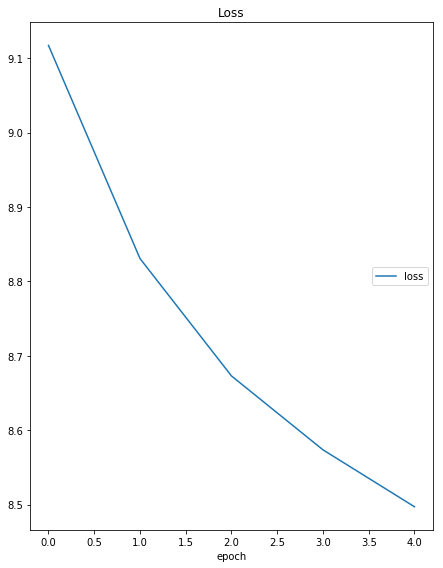

Loss
	loss             	 (min:    8.497, max:    9.117, cur:    8.497)
batch nr 0, loss: 8.644938468933105


batch nr 10, loss: 6.633915901184082
batch nr 20, loss: 8.115044593811035
batch nr 30, loss: 7.235907077789307
batch nr 40, loss: 10.597047805786133
batch nr 50, loss: 9.586009979248047
batch nr 60, loss: 7.390157699584961
batch nr 70, loss: 9.407181739807129
batch nr 80, loss: 8.967031478881836
batch nr 90, loss: 6.538474082946777
batch nr 100, loss: 11.395977020263672
batch nr 110, loss: 7.943320274353027
batch nr 120, loss: 6.704046249389648
batch nr 130, loss: 7.639678478240967
batch nr 140, loss: 9.908987045288086
batch nr 150, loss: 6.915326118469238
batch nr 160, loss: 8.841913223266602
batch nr 170, loss: 11.332972526550293
batch nr 180, loss: 4.581040859222412
batch nr 190, loss: 9.447489738464355
batch nr 200, loss: 11.95538330078125
batch nr 210, loss: 7.7991814613342285
batch nr 220, loss: 7.0595598220825195
batch nr 230, loss: 9.53773021697998
batch nr 240, loss: 11.593940734863281
batch nr 250, loss: 8.208016395568848
batch nr 260, loss: 10.001124382019043
batch nr 270, l

batch nr 2140, loss: 8.28591251373291
batch nr 2150, loss: 8.968286514282227
batch nr 2160, loss: 13.376763343811035
batch nr 2170, loss: 8.943116188049316
batch nr 2180, loss: 7.619041919708252
batch nr 2190, loss: 9.41816520690918
batch nr 2200, loss: 12.604105949401855
batch nr 2210, loss: 8.343395233154297
batch nr 2220, loss: 9.297892570495605
batch nr 2230, loss: 8.513386726379395
batch nr 2240, loss: 6.96315860748291
batch nr 2250, loss: 7.371601104736328
batch nr 2260, loss: 7.7474493980407715
batch nr 2270, loss: 6.58005952835083
batch nr 2280, loss: 7.262411117553711
batch nr 2290, loss: 6.943281173706055
batch nr 2300, loss: 9.118218421936035
batch nr 2310, loss: 9.102378845214844
batch nr 2320, loss: 7.70840311050415
batch nr 2330, loss: 7.189428806304932
batch nr 2340, loss: 6.970585823059082
batch nr 2350, loss: 12.161972045898438
batch nr 2360, loss: 8.21742057800293
batch nr 2370, loss: 14.71873664855957
batch nr 2380, loss: 8.025952339172363
batch nr 2390, loss: 7.3413

In [ ]:
## training loop with adam

BATCH_SIZE=1
batched_trn_dataset=trn_dataset.shuffle(10000).batch(BATCH_SIZE,drop_remainder=True)

# 1e-4 was good for saxophone (got us to 4.7-ish in 20 hours our so)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

e=0
while True:
  batch_counter=0
  epoch_loss=0   
  for batch in batched_trn_dataset:
    with tf.GradientTape() as tape:
        output=ae(batch,train_shared=True)
        loss_value=spectral_loss(batch["audio"],output["audio_synth"])
        gradients = tape.gradient(loss_value, ae.trainable_variables)
        epoch_loss+=loss_value.numpy()
        optimizer.apply_gradients(zip(gradients, ae.trainable_variables))
        
    if batch_counter % 10==0:
        print(f"batch nr {batch_counter}, loss: {loss_value.numpy()}")

    if batch_counter ==0:    
        play(tf.reshape(output["audio"],(-1)))
        play(tf.reshape(output['audio_synth'],(-1)))
        play(tf.reshape(output['harmonic+fn']["signal"],(-1))) 
        play(tf.reshape(output['harmonic']["signal"],(-1))) 
        play(tf.reshape(output["fn"]["signal"],(-1)))
        play(tf.reshape(output["ir"],(-1)))

    batch_counter+=1

  plotlosses.update({'loss': epoch_loss/batch_counter,})
  plotlosses.send()
  ae.save_weights(checkpoint_path)
  e+=1

In [ ]:
# define some data utilities

def join_batch(batch):
    for key in batch.keys():
        assert len(batch[key].shape)<3
        if len(batch[key].shape)==2:
            batch[key]=tf.reshape(batch[key],(1,-1))
    return batch
     
def window_signal(a,window_len,hop_len):
     assert(a.shape[0]==1)
     windows=[]
     start_frame=0
     while True:
        windows.append(a[:,start_frame:start_frame+window_len,...])
        start_frame+=hop_len
        if start_frame > a.shape[1]-window_len:
            break
     return tf.concat(windows,axis=0)

def window_sample(instance,win_s,hop_s):
    instance["audio"]=window_signal(instance["audio"],win_s*SAMPLE_RATE,hop_s*SAMPLE_RATE)
    for key in ["f0_hz","loudness_db","f0_confidence"]:
        instance[key]=window_signal(instance[key],win_s*FT_FRAME_RATE,hop_s*FT_FRAME_RATE)
    instance["instrument"]=tf.repeat(instance["instrument"][0],(instance["audio"].shape[0]))
    instance["instrument_idx"]=tf.repeat(instance["instrument_idx"][0],(instance["audio"].shape[0]))
    for key,item in instance.items():
        assert(len(item.shape)<2 or item.shape[0]>1)
    return instance

def join_and_window(instance,win_s=4,hop_s=1):
    return window_sample(join_batch(instance),win_s,hop_s)

def rf2cf(row_form):
    return {k:[s[k] for s in row_form] for k in row_form[0].keys()}

# few shot voice cloning

ACCUMULATE_GRADIENTS=4
# constants
BATCH_SIZE=1
N_FIT_ITERATIONS=100
VAL_LR=1e-5
N_DEMO_SAMPLES=int(4*SAMPLE_RATE)
N_FIT_SECONDS=32

DEMO_IR_DURATION=0.5

n_fit_windows=int(N_FIT_SECONDS/CLIP_S)
val_dataset=list(val_dataset)

# group by instrument id
val_dataset_by_instrument=pydash.collections.group_by(list(val_dataset),lambda x: str(x["instrument"].numpy()))
val_dataset_by_instrument = {k:v for k,v in val_dataset_by_instrument.items() if len(v)>n_fit_windows*2}

# load model
ae_test = MultiInstrumentAutoencoder(
preprocessor=preprocessor,
decoder=decoder,
processor_group=processor_group,
n_instruments=N_INSTRUMENTS,
instrument_weight_metadata=instrument_weight_metadata
)

# load model weights       

ae_test.set_is_shared_trainable(True)
ae_test.load_weights(checkpoint_path)

ae_test.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: 0.01*tf.zeros([batch_size,int(DEMO_IR_DURATION*SAMPLE_RATE)])
#ae_test.instrument_weight_metadata["ir"]["processing"]=lambda batched_feature: tf.tanh(batched_feature)
ae_test.initialize_instrument_weights()
ae_test.set_is_shared_trainable(True)

TMP_CHECKPOINT_PATH="artefacts/tmp_checkpoint"
ae_test.save_weights(TMP_CHECKPOINT_PATH)

for ii,instrument_set in enumerate(reversed(list(val_dataset_by_instrument.values()))): 
    
    print(f"instrument nr {ii}")
    
    ae_test.set_is_shared_trainable(True)
    ae_test.load_weights(TMP_CHECKPOINT_PATH)
    ae_test.initialize_instrument_weights()

    # data
    # reshape data
    fit_data=instrument_set[:n_fit_windows]
    test_data=instrument_set[n_fit_windows:n_fit_windows*2]
    
    # convert to column form
    fit_data = rf2cf(fit_data)
    
    # get one batch for fitting
    fit_batch= next(iter(tf.data.Dataset.from_tensor_slices(fit_data).batch(len(list(fit_data)))))
    
    print("training data excerpt")
    play(tf.reshape(fit_data["audio"],[-1]))
    
    # transform data so that the clips overlap
    fit_batch=join_and_window(fit_batch,4,1)
    fit_data=tf.data.Dataset.from_tensor_slices(fit_batch)
    fit_batched=fit_data.batch(BATCH_SIZE)
    
    # prepare test data
    test_data = rf2cf(test_data)
    test_batched= tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE)
    
    fit_losses=[]
    tst_losses=[]
    
    # set up optimizer
    val_optimizer = tf.keras.optimizers.Adam(learning_rate=VAL_LR)
    
    for i in tqdm.tqdm(range(N_FIT_ITERATIONS)):
        fit_batched=fit_batched.shuffle(100)
        
        epoch_loss=0
        batch_counter=0
        test_epoch_loss=0
        test_batch_counter=0
        
        
        ae_test.set_is_shared_trainable(True)
        
        if ACCUMULATE_GRADIENTS>1:
            # get trainable variables
            train_vars = ae_test.trainable_variables
            # Create empty gradient list (not a tf.Variable list)
            for fit_batch in fit_batched:
                if  batch_counter%ACCUMULATE_GRADIENTS==0:
                    accum_counter=0
                    accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
                with tf.GradientTape() as tape:
                  output=ae_test(fit_batch,train_shared=True)
                  loss_value=spectral_loss(fit_batch["audio"],output["audio_synth"])
                  epoch_loss+=loss_value.numpy()
                  batch_counter+=1
                  accum_counter+=1
                gradients = tape.gradient(loss_value, train_vars)
                # Accumulate the gradients
                accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
                if batch_counter%ACCUMULATE_GRADIENTS==ACCUMULATE_GRADIENTS-1:
                    accum_gradient = [this_grad/accum_counter for this_grad in accum_gradient]    
                    val_optimizer.apply_gradients(zip(accum_gradient, train_vars))
            fit_losses.append(epoch_loss/batch_counter)
        else:
            for fit_batch in fit_batched:
                with tf.GradientTape() as tape:
                  output=ae_test(fit_batch,train_shared=True)
                  loss_value=spectral_loss(fit_batch["audio"],output["audio_synth"])
                  epoch_loss+=loss_value.numpy()
                  batch_counter+=1
                  gradients = tape.gradient(loss_value, ae_test.trainable_weights)
                val_optimizer.apply_gradients(zip(gradients, ae_test.train_vars))
            fit_losses.append(epoch_loss/batch_counter)
            
        
        for test_batch in test_batched:
            test_output=ae_test(test_batch,train_shared=False)
            loss_value=spectral_loss(test_batch["audio"],test_output["audio_synth"])   
            test_epoch_loss+=loss_value.numpy()
            test_batch_counter+=1
        tst_losses.append(test_epoch_loss/test_batch_counter)
        
        # loss plot
        plt.plot(tst_losses,label="tst")
        plt.plot(fit_losses,label="trn")
        plt.legend()
        plt.show()
        
        print("target")        
        play(tf.reshape(fit_batch["audio"],(-1)))

        print("estimate")     
        play(tf.reshape(output['audio_synth'],(-1)))
    
        if i%5==0:
            # loss plot
            plt.plot(tst_losses,label="tst")
            plt.plot(fit_losses,label="trn")
            plt.legend()
            plt.show()
    
    plt.plot(tst_losses,label="tst")
    plt.plot(fit_losses,label="trn")
    plt.legend()
    plt.show()

    print(">> seen data:")
            
    print("target")        
    play(tf.reshape(fit_batch["audio"],(-1)))
    
    print("estimate")     
    play(tf.reshape(output['audio_synth'],(-1)))
    
    print("transposed down")
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*0.7
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    print("transposed up") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*1.3
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    print("very lower loudness") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-12
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    print("lower loudness") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-6
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
        
    print("higher loudness") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+6
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
        
    print("very higher loudness") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+12
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
     
    print("no confidence") 
    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_confidence"]=transposed_fit_batch["f0_confidence"]*0.0
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
    print(">> unseen data:")
    print("target")
    play(tf.reshape(test_batch["audio"][:,:N_DEMO_SAMPLES],(-1)))
     
    print("estimate")    
    test_batch_output = ae_test(test_batch,train_shared=False)
    play(tf.reshape(test_batch_output['audio_synth'][:,:N_DEMO_SAMPLES],(-1)))

In [ ]:
 # timbre transfer unseen passage
import librosa

Y,sr = librosa.load("artefacts/schnitzle.wav",sr=16000)

outs=[]
for i in range(Y.shape[0]//N_SAMPLES):
    y=Y[i*N_SAMPLES:min(N_SAMPLES*(i+1),Y.shape[0])]
    
    if y.shape[0]<N_SAMPLES:
        yn=np.zeros((N_SAMPLES))
        yn[:y.shape[0]]=y
        y=yn
        
    ld_db=ddsp.spectral_ops.compute_loudness(y)

    f0_hz,f0_confidence = ddsp.spectral_ops.compute_f0(y,sample_rate=SAMPLE_RATE,frame_rate=FT_FRAME_RATE)

    BATCH_SIZE=10

    db_boost=0

    start_index=0
    controls = {"loudness_db":tf.tile(ld_db[None,:],[BATCH_SIZE,1])+db_boost,"f0_hz":tf.tile(f0_hz[None,:],[BATCH_SIZE,1]),"f0_confidence":tf.tile(f0_confidence[None,:],[BATCH_SIZE,1]),"instrument_idx":start_index+tf.cast(tf.linspace(0,BATCH_SIZE-1,BATCH_SIZE),tf.int32)}

    for key in controls.keys():
        print(controls[key].shape)

    outs.append(ae(controls,train_shared=False)["audio_synth"])
    
print(outs)
outs = tf.concat(outs,axis=-1)

print(outs.shape)

play(tf.reshape(outs,(-1)))